## Plant disease classification with PyTorch

In [2]:
import torch
import glob
import os
import cv2
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchinfo import summary
import numpy as np
from collections import defaultdict

### Download and extract data

In [3]:
# Uncomment to download data - 1.3GB 
# !curl -L -o ~/Downloads/plant-disease-recognition-dataset.zip\
#   https://www.kaggle.com/api/v1/datasets/download/rashikrahmanpritom/plant-disease-recognition-dataset
# !unzip ~/Downloads/plant-disease-recognition-dataset.zip -d ./data

In [4]:
train_path = "./data/Train/"
test_path = "./data/Test/"
validation_path = "./data/Validation/"
train_images = glob.glob(train_path+"**/*.jpg", recursive=True)
test_images = glob.glob(test_path+"**/*.jpg", recursive=True)
validation_images = glob.glob(validation_path+"**/*.jpg", recursive=True)

In [5]:
train_images[-2:]
#len(train_images)

['./data/Train/Rust/dfcc6b28063a88fc.jpg',
 './data/Train/Rust/aacedff0d881c189.jpg']

In [6]:
class PlantsLeavesDataset(Dataset):
    """Plants leaves dataset."""

    def __init__(self, image_paths, transform=None):
        """
        """
        self.label_map = {'Healthy': 0, 'Powdery':1, 'Rust':2}
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_paths[idx]
        image = cv2.imread(img_name)
        label_name = img_name.split('/')[-2]
        label = self.label_map[label_name]
        # label = np.array([label], dtype=float)

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512)),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(35),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512)),
])

In [8]:
train_set = PlantsLeavesDataset(train_images, train_transform)
test_set = PlantsLeavesDataset(test_images, test_transform)
validation_set = PlantsLeavesDataset(validation_images, test_transform)

In [9]:
# shapes = defaultdict(int)
# for i in range(len(train_set)):
#     s = tuple(train_set[i][0].shape)
#     shapes[s] += 1
# shapes

In [10]:
batch_size = 64
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(validation_set, shuffle=False, batch_size=batch_size, drop_last=True)

In [11]:
next(iter(train_loader))

[tensor([[[[0.8463, 0.8374, 0.8175,  ..., 0.3954, 0.3984, 0.3991],
           [0.8488, 0.8472, 0.8209,  ..., 0.4012, 0.4060, 0.4032],
           [0.8507, 0.8504, 0.8235,  ..., 0.4013, 0.4044, 0.4046],
           ...,
           [0.4277, 0.4320, 0.4456,  ..., 0.3107, 0.2506, 0.2256],
           [0.4347, 0.4421, 0.4396,  ..., 0.2547, 0.2040, 0.1942],
           [0.4415, 0.4459, 0.4397,  ..., 0.2015, 0.1704, 0.1657]],
 
          [[0.9248, 0.9174, 0.9072,  ..., 0.5831, 0.5790, 0.5795],
           [0.9272, 0.9254, 0.9139,  ..., 0.5867, 0.5849, 0.5836],
           [0.9291, 0.9292, 0.9158,  ..., 0.5869, 0.5841, 0.5841],
           ...,
           [0.6934, 0.6991, 0.7013,  ..., 0.5795, 0.5251, 0.5134],
           [0.6893, 0.6963, 0.6942,  ..., 0.5297, 0.4969, 0.5038],
           [0.6871, 0.6925, 0.6933,  ..., 0.4860, 0.4791, 0.4917]],
 
          [[0.9953, 0.9888, 0.9890,  ..., 0.4183, 0.4143, 0.4148],
           [0.9972, 0.9944, 0.9939,  ..., 0.4226, 0.4203, 0.4189],
           [0.9986, 0.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.076204754..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.032952238..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.035708684..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.077736944..1.0000002].


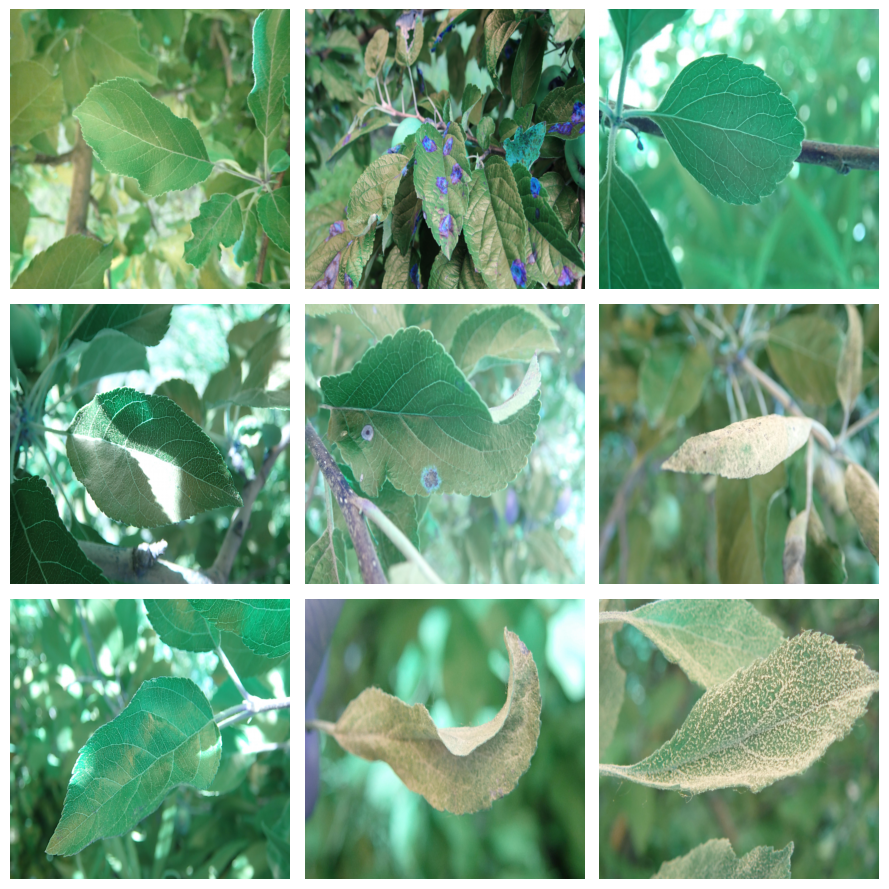

In [12]:
ims, labels = next(iter(train_loader))
ims = torch.einsum("bchw->bhwc", ims)
rows, cols = 3, 3
ims = ims[:rows*cols].view(rows, cols, 512, 512, 3)
fig, axs = plt.subplots(rows, cols, figsize=(3*rows, 3*cols))
for A, I in zip(axs,ims):
    for ax, img in zip(A,I):
        ax.set_aspect('equal')
        ax.axis('off')
        ax.imshow(img)
fig.tight_layout()
#fig.subplots_adjust(hspace=0, wspace=0)
#plt.savefig(save_fig_path, facecolor='w', edgecolor='none')
plt.show()


In [16]:
"""
conv1: 512 -> 256 : 8
conv2: 256 -> 128 : 16
res
conv3: 128 -> 64 : 32
conv4: 64 -> 32 : 64
res
conv5: 32 -> 16 : 128
conv6: 16 -> 8 : 256
res
conv7: 8 -> 4 : 512
conv8: 4 -> 2 : 1024
res
flatten: 1024 x 2 x 2
linear1: 512
linear2: 128
linear3: 32
linear4: 3
"""

# Conv block used in Resnet model
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same'),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

# Linear layer block
def linear_block(in_features, out_features, activation=True, batchnorm=False, flatten=False):
    layers = []
    if flatten:
        layers.append(nn.Flatten())
    layers.append(nn.Linear(in_features, out_features))
    if batchnorm:
        layers.append(nn.BatchNorm1d(out_features))
    if activation:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

# Resnet9
class RESNET20(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(RESNET20, self).__init__()
        self.conv1 = conv_block(in_channels, 8, pool=True)
        self.conv2 = conv_block(8, 16, pool=True)
        self.res1 = nn.Sequential(conv_block(16, 16), conv_block(16, 16))

        self.conv3 = conv_block(16, 32, pool=True)
        self.conv4 = conv_block(32, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))

        self.conv5 = conv_block(64, 128, pool=True)
        self.conv6 = conv_block(128, 256, pool=True)
        self.res3 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

        self.conv7 = conv_block(256, 512, pool=True)
        self.conv8 = conv_block(512, 1024, pool=True)
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))

        # dense layers
        self.fc1 = linear_block(1024*2*2, 512, flatten=True)
        self.fc2 = linear_block(512, 128)
        self.fc3 = linear_block(128, 32)
        self.fc4 = linear_block(32, num_classes, activation=False)

    def forward(self, x):
        x = self.conv2(self.conv1(x))
        x = self.res1(x) + x
        x = self.conv4(self.conv3(x))
        x = self.res2(x) + x
        x = self.conv6(self.conv5(x))
        x = self.res3(x) + x
        x = self.conv8(self.conv7(x))
        x = self.res4(x) + x
        return self.fc1(x)
        x = self.fc2(self.fc1(x))
        return self.fc4(self.fc3(x))

    def model_summary(self):
        return summary(self, input_size=(3,512,512))


In [17]:
test_input = torch.randn((64,3,512,512))
test_model = RESNET20(3,3)
test_out = test_model(test_input)
test_out.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (131072x2 and 4096x512)

torch.Size([64, 1024, 2, 2])